In [2]:
#%reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
hfont = {'fontname':'Helvetica'}

#oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=10) #need for neural network and random forest
import pickle


In [3]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2028/3165355871.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')


In [4]:
def merge_and_rename_data(data1, data2, on_column, suffix1, suffix2):
    merged_data = pd.merge(data1, data2, on=on_column, suffixes=('_'+suffix1, '_'+suffix2))

    new_column_names = [col.replace(f'_{on_column}_{suffix1}', f'_{suffix1}').replace(f'_{on_column}_{suffix2}', f'_{suffix2}') for col in merged_data.columns]
    merged_data.rename(columns=dict(zip(merged_data.columns, new_column_names)), inplace=True)

    return merged_data

def pivot_data_by_HSA(data, index_column, columns_column, values_column):
    data_by_HSA = data[[index_column, columns_column, values_column]]
    pivot_table = data_by_HSA.pivot_table(index=index_column, columns=columns_column, values=values_column)
    return pivot_table

def create_column_names(categories_for_subsetting, num_of_weeks):
    column_names = ['HSA_ID']

    for week in range(1, num_of_weeks + 1):
        week = num2words(week)
        for category in categories_for_subsetting:
            column_name = f'week_{week}_{category}'
            column_names.append(column_name)

    return column_names
    
def create_collated_weekly_data(pivoted_table, original_data, categories_for_subsetting, geography, column_names):
    collated_data = pd.DataFrame(index=range(51), columns=column_names)

    x = 0
    for geo in original_data[geography].unique():
        #matching_indices = [i for i, geo_col in enumerate(pivoted_table) if geo_col == geo]
        collated_data.loc[x, geography] = geo
        columns_to_subset = [f'{geo}_{category}' for category in categories_for_subsetting]
        j = 1
        try:
            for row in range(len(pivoted_table.loc[:, columns_to_subset])):
                collated_data.iloc[x, j:j + len(categories_for_subsetting)] = pivoted_table.loc[row, columns_to_subset]
                j += len(categories_for_subsetting)
        except:
            pass
        x += 1

    return collated_data


def add_changes_by_week(weekly_data_frame, outcome_column):

    for column in weekly_data_frame.columns[1:]:
        # Calculate the difference between each row and the previous row
        if outcome_column not in column.lower(): #want to leave out the outcome column
            diff = weekly_data_frame[column].diff()
            
            # Create a new column with the original column name and "delta"
            new_column_name = column + "_delta"
            
            column_index = weekly_data_frame.columns.get_loc(column)
            
            # Insert the new column just after the original column
            weekly_data_frame.insert(column_index + 1, new_column_name, diff)
            weekly_data_frame[new_column_name] = diff
    return weekly_data_frame


def prep_training_test_data_period(data, no_weeks, weeks_in_futre, if_train, geography, weight_col, keep_output):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    y_weeks_to_check = [] #check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        for week_y in range(week+1, test_week+1):
                y_weeks_to_check.append('_' + num2words(week_y) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
            train_week = w2n.word_to_num(x_week.replace("_", ""))
            target_week =  w2n.word_to_num(y_week.replace("_", ""))
            y_weeks_to_check = []
            for week_to_check in range(train_week + 1, target_week + 1):
                y_weeks_to_check.append('_' + num2words(week_to_check) + '_')

            y_weeks_to_check = [week + 'beds_over_15_100k' for week in y_weeks_to_check]
            columns_to_check = [col for col in data.columns if any(week in col for week in y_weeks_to_check)]
            y_over_in_period = data[columns_to_check].apply(max, axis=1)
            data_y = pd.concat([data_y, y_over_in_period], axis=1)
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            if keep_output:
                X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and  "target" for that week

                #rename columns for concatenation 
                X_week.columns = range(1, len(data_x.columns) -1)
            else:
                X_week = X_week.iloc[:, :len(X_week.columns)-2] # remove the weights and  "target" for that week
            y_week.columns = range(1, len(data_y.columns) -2)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)

### this code it's ANY in the x week period 

### this code it's ANY in the x week period 
def prep_training_test_data(data, no_weeks, weeks_in_futre, if_train, geography, weight_col, keep_output):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1
            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            if keep_output:
                X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and leave "target" for that week

                #rename columns for concatenation 
                X_week.columns = range(1, len(data_x.columns) -1)
            else:
                X_week = X_week.iloc[:, :len(X_week.columns)-2] # remove the weights and  "target" for that week

                X_week.columns = range(1, len(data_x.columns) -2)# remove the weights and  "target" for that week

                #rename columns for concatenation 
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)


def calculate_ppv_npv(confusion_matrix):
    # Extract values from the confusion matrix
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1]
    TN = confusion_matrix[0, 0]
    FN = confusion_matrix[1, 0]

    # Calculate PPV (Precision) and NPV
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0.0

    return ppv, npv

In [5]:
for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i

In [6]:
## pivot 
data_by_HSA_cases = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_admissions = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_percent_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_over_15_100k = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_over_15_100k')

## merge 
data_by_HSA_cases_admits = merge_and_rename_data(data_by_HSA_cases, data_by_HSA_admissions,'week','cases', 'admits')
data_by_HSA_admits_perc_outcome = merge_and_rename_data(data_by_HSA_percent_beds, data_by_HSA_over_15_100k,'week','perc_covid', 'beds_over_15_100k')
data_by_HSA_cases_admits_perc_outcome= pd.merge(data_by_HSA_cases_admits, data_by_HSA_admits_perc_outcome, on='week')


data_by_HSA_cases_admits_perc_outcome = data_by_HSA_cases_admits_perc_outcome.reset_index()
data_by_HSA_cases_admits_perc_outcome.columns = data_by_HSA_cases_admits_perc_outcome.columns.str.replace(',', '')

In [7]:
categories_for_subsetting = ['cases', 'admits','perc_covid', 'beds_over_15_100k']
num_of_weeks = len(data_by_HSA_cases_admits_perc_outcome)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

In [8]:
all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_cases_admits_perc_outcome, data_by_HSA, categories_for_subsetting, 'HSA_ID', column_names)

In [9]:
weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

# Period

In [15]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight',  keep_output = False)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,  no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight',  keep_output = False)
weights = weights[0].to_numpy()

Accuracy: 0.8106944310549825
auROC: 0.8045169959447633
[[ 5327  1385]
 [ 4506 19901]]


[Text(0.5, 0.9, 'perc_covid <= 0.019\ngini = 0.5\nsamples = 65573\nvalue = [40.83, 40.83]'),
 Text(0.25, 0.7, 'perc_covid <= 0.01\ngini = 0.269\nsamples = 15690\nvalue = [36.18, 6.904]'),
 Text(0.125, 0.5, 'admits <= 1.558\ngini = 0.184\nsamples = 10116\nvalue = [31.34, 3.582]'),
 Text(0.0625, 0.3, 'cases <= 35.5\ngini = 0.121\nsamples = 5854\nvalue = [22.759, 1.571]'),
 Text(0.03125, 0.1, 'gini = 0.083\nsamples = 2669\nvalue = [11.977, 0.543]'),
 Text(0.09375, 0.1, 'gini = 0.159\nsamples = 3185\nvalue = [10.782, 1.028]'),
 Text(0.1875, 0.3, 'cases <= 115.5\ngini = 0.308\nsamples = 4262\nvalue = [8.581, 2.011]'),
 Text(0.15625, 0.1, 'gini = 0.275\nsamples = 3223\nvalue = [7.289, 1.434]'),
 Text(0.21875, 0.1, 'gini = 0.427\nsamples = 1039\nvalue = [1.291, 0.577]'),
 Text(0.375, 0.5, 'admits <= 2.508\ngini = 0.483\nsamples = 5574\nvalue = [4.841, 3.322]'),
 Text(0.3125, 0.3, 'cases <= 21.5\ngini = 0.39\nsamples = 1526\nvalue = [2.239, 0.81]'),
 Text(0.28125, 0.1, 'gini = 0.287\nsamples =

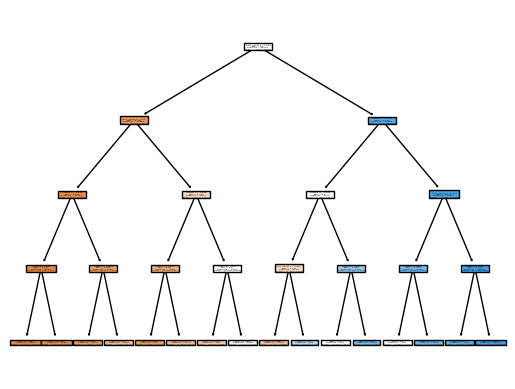

In [18]:
param_grid = {
    'criterion': ['gini'],#,  'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split':  np.arange(2, 300), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 400)}#, #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }


# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=100, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases', 'admits','perc_covid'], filled=True)
#plt.savefig('Graphs/Optimized_CDC_classifier.png', dpi = 300)

In [74]:
best_params

{'min_samples_split': 123,
 'min_samples_leaf': 385,
 'max_depth': 4,
 'criterion': 'gini'}

In [ ]:
plot_tree(clf, feature_names=['cases', 'admits','perc_covid'], filled=True)
#plt.savefig('Graphs/Optimized_CDC_classifier.png', dpi = 300)

In [14]:
model_name = "CDC_optimized_auroc_0.8158681191554998.sav" 
pickle.dump(clf, open(model_name, 'wb'))
#clf = pickle.load(open(model_name, 'rb'))

Number of nodes in the last tree is: 3 with ccp_alpha: 0.25785556672039545


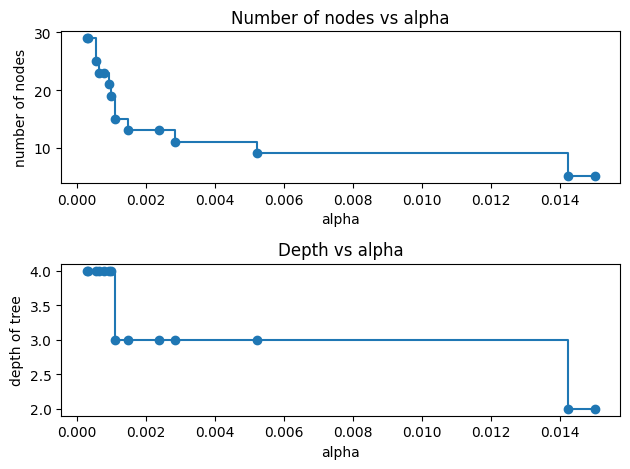

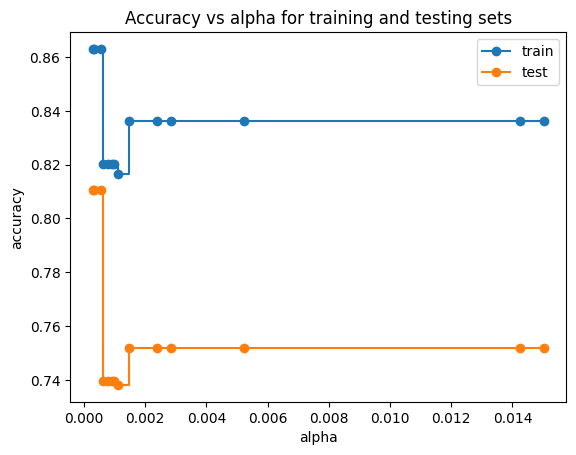

In [80]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas = [alpha for alpha in ccp_alphas if alpha > 0]

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=ccp_alpha,  class_weight='balanced')
    clf.fit(X_train, y_train,  sample_weight = weights)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

0.7829655543923804


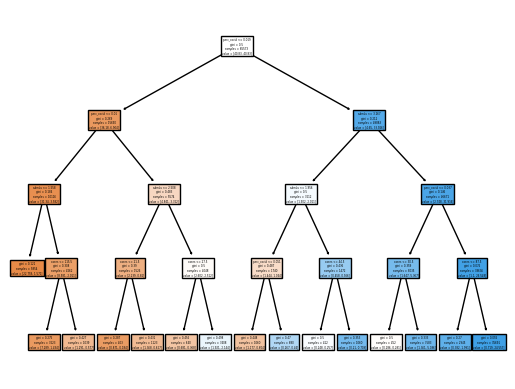

In [82]:
clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=0.00028489450886638734,  class_weight='balanced')
clf.fit(X_train, y_train,  sample_weight = weights)
plot_tree(clf, feature_names=['cases', 'admits','perc_covid'], filled=True)
print(roc_auc_score(y_test[0], y_pred))

Which weeks had the highest predictive capacity 

In [ ]:
weeks_to_predict = range(1,123) ## three being the actual prediction week 
ROC_by_week = []
#
for prediction_week in weeks_to_predict: 
    
    X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data, no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID', weight_col = 'weight', keep_output = False)

    X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data, no_weeks = range(int(123*2/3) + 1, 122), weeks_in_futre = prediction_week, if_train = False, geography = 'HSA_ID',  weight_col = 'weight', keep_output = False)
    weights = weights[0]
    clf.fit(X_train, y_train,  sample_weight = weights)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    ROC_by_week.append(roc_auc_score(y_test, y_pred))
ROC_by_week # not good on any individual week

# Exactly t+3

In [39]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight', keep_output = False)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,  no_weeks = range(int(123*2/3) + 1, 120), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight', keep_output = False)
weights = weights[0].to_numpy()

In [40]:
all_HSA_ID_weekly_data

,HSA_ID,week_one_cases,week_one_admits,week_one_perc_covid,week_one_beds_over_15_100k,week_two_cases,week_two_admits,week_two_perc_covid,week_two_beds_over_15_100k,week_three_cases,...,week_one hundred and twenty_beds_over_15_100k,week_one hundred and twenty-one_cases,week_one hundred and twenty-one_admits,week_one hundred and twenty-one_perc_covid,week_one hundred and twenty-one_beds_over_15_100k,week_one hundred and twenty-two_cases,week_one hundred and twenty-two_admits,week_one hundred and twenty-two_perc_covid,week_one hundred and twenty-two_beds_over_15_100k,weight
0,1,26.0,1.318896,0.002834,0.0,37.0,2.637792,0.007075,0.0,55.0,...,1.0,128.0,5.935031,0.026286,1.0,104.0,1.318896,0.012571,0.0,0.001245
1,2,50.0,0.903565,0.0,0.0,85.0,3.614259,0.0,0.0,67.0,...,1.0,95.0,4.404878,0.029489,1.0,98.0,3.501314,0.013859,0.0,0.001245
2,3,59.0,0.670565,0.003202,0.0,86.0,4.442492,0.022361,1.0,85.0,...,1.0,91.0,8.633523,0.034866,1.0,80.0,3.771927,0.014157,1.0,0.001245
3,4,15.0,0.345059,0.001074,0.0,17.0,1.854691,0.005092,0.0,46.0,...,1.0,109.0,12.033923,0.051009,1.0,71.0,1.897823,0.006715,0.0,0.001245
4,5,114.0,2.631851,0.00881,0.0,139.0,11.279362,0.026236,1.0,112.0,...,1.0,117.0,3.195819,0.027698,1.0,109.0,1.879894,0.009452,0.0,0.001245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,904,49.0,0.939351,0.002749,0.0,73.0,0.0,0.0,0.0,88.0,...,1.0,195.0,3.13117,0.011949,1.0,175.0,0.751481,0.002236,0.0,0.001245
800,122,NaN,NaN,NaN,NaN,7.0,0.0,0.0,0.0,7.0,...,1.0,143.0,6.873915,0.055498,1.0,108.0,3.436958,0.006166,0.0,0.001245
801,793,NaN,NaN,NaN,NaN,61.0,14.399677,0.045714,1.0,63.0,...,0.0,259.0,5.759871,0.065789,1.0,318.0,0.0,0.0,0.0,0.001245
802,788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,...,0.0,44.0,29.027576,0.0,0.0,29.0,0.0,0.0,0.0,0.001245


Accuracy: 0.7506766815536609
auROC: 0.754164381495622
[[ 7280  2249]
 [ 5120 14907]]


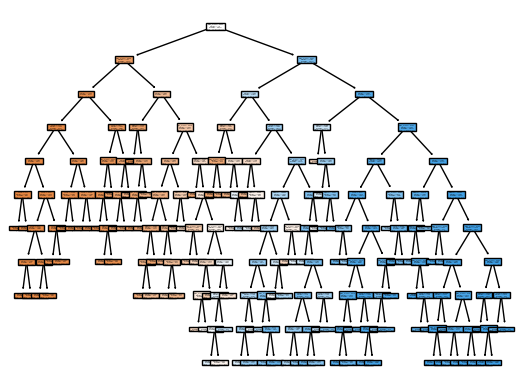

In [11]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 20, 2),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf_exact = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf_exact, param_grid, n_iter=500, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_
best_params = {'min_samples_split': 350,
 'min_samples_leaf': 300,
 'max_depth': 10,
 'criterion': 'entropy'}
# Create the Decision Tree classifier with the best hyperparameters
#clf = DecisionTreeClassifier(**best_params, random_state=100, class_weight='balanced')
clf_exact = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf_exact.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf_exact.predict(X_test)
y_pred_proba = clf_exact.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC)
print(confusion_matrix(y_test, y_pred))
plot_tree(clf_exact, feature_names=['cases', 'admits','perc_covid'], filled=True)
plt.savefig('Graphs/Optimized_CDC_classifier.png', dpi = 300)

In [16]:
y_pred = clf_exact.predict(X_test)
y_pred_proba = clf_exact.predict_proba(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC)

Accuracy: 0.7506766815536609
auROC: 0.8255321995964489


In [12]:
best_params

{'min_samples_split': 350,
 'min_samples_leaf': 300,
 'max_depth': 10,
 'criterion': 'entropy'}

In [18]:
model_name = f"CDC_optimized_exact_auroc_{ROC:.4f}_unpruned.sav"
pickle.dump(clf_exact, open(model_name, 'wb'))
#clf_exact = pickle.load(open('CDC_optimized_exact_auroc_0.7542_unpruned.sav', 'rb'))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2672750177529526


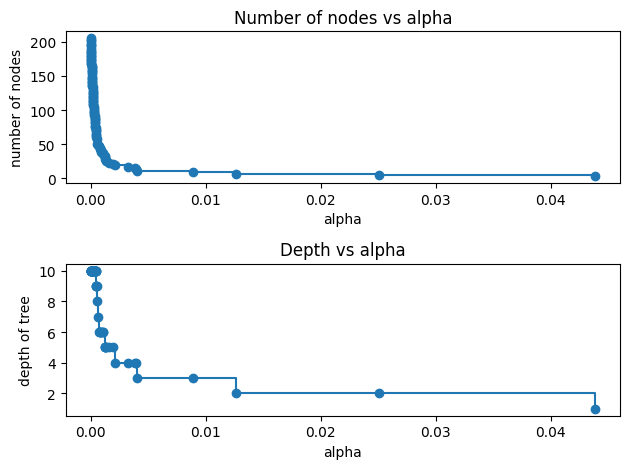

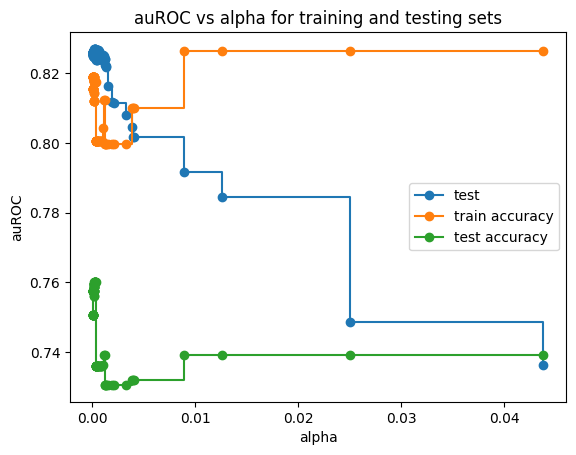

In [24]:
path = clf_exact.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas = [alpha for alpha in ccp_alphas if alpha > 0]

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=ccp_alpha,  class_weight='balanced')
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

test_scores = [roc_auc_score(y_test[0], clf.predict_proba(X_test)[:, 1]) for clf in clfs]
train_scores_accuracy = [clf.score(X_train, y_train) for clf in clfs]
test_scores_accuracy  = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("auROC")
ax.set_title("auROC vs alpha for training and testing sets")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.plot(ccp_alphas, train_scores_accuracy, marker="o", label="train accuracy", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_accuracy, marker="o", label="test accuracy", drawstyle="steps-post")
ax.legend()
plt.show()

Accuracy: 0.7601502233049127
auROC: 0.8269425031585678
[[ 7175  2354]
 [ 4735 15292]]


[Text(0.3558070866141732, 0.9545454545454546, 'deaths <= 0.021\nentropy = 1.0\nsamples = 65578\nvalue = [40.833, 40.833]'),
 Text(0.15354330708661418, 0.8636363636363636, 'deaths <= 0.005\nentropy = 0.67\nsamples = 16395\nvalue = [30.344, 6.448]'),
 Text(0.07874015748031496, 0.7727272727272727, 'delta_cases <= 0.983\nentropy = 0.443\nsamples = 8105\nvalue = [20.8, 2.105]'),
 Text(0.047244094488188976, 0.6818181818181818, 'cases <= 77.5\nentropy = 0.343\nsamples = 5117\nvalue = [14.83, 1.012]'),
 Text(0.031496062992125984, 0.5909090909090909, 'cases <= 12.5\nentropy = 0.289\nsamples = 3464\nvalue = [10.659, 0.569]'),
 Text(0.015748031496062992, 0.5, 'entropy = 0.197\nsamples = 840\nvalue = [2.845, 0.089]'),
 Text(0.047244094488188976, 0.5, 'entropy = 0.319\nsamples = 2624\nvalue = [7.814, 0.48]'),
 Text(0.06299212598425197, 0.5909090909090909, 'entropy = 0.456\nsamples = 1653\nvalue = [4.17, 0.443]'),
 Text(0.11023622047244094, 0.6818181818181818, 'cases <= 78.5\nentropy = 0.622\nsample

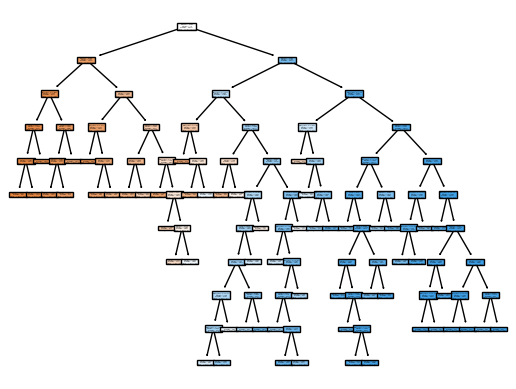

In [26]:
clf_exact = clfs[test_scores.index(max(test_scores))]


clf_exact.fit(X_train, y_train,  sample_weight = weights)

    # Make predictions on the test set
y_pred = clf_exact.predict(X_test)
y_pred_proba = clf_exact.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf_exact, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)
#plt.savefig('Graphs/Optimized_CDC_classifier_pruned.png', dpi = 300)

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred)

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

# Calculate specificity (true negative rate)
specificity = TN / (TN + FP)
print(specificity)
# Calculate sensitivity (true positive rate)
sensitivity = TP / (TP + FN)
print(sensitivity)

ppv, npv = calculate_ppv_npv(conf_matrix)
print(ppv)
print(npv)

0.7529646342743205
0.7635691816048334
0.8665986625864218
0.6024349286314021


In [28]:
model_name = f"CDC_optimized_exact_auroc_{ROC:.4f}_pruned.sav"
pickle.dump(clf_exact, open(model_name, 'wb'))

# Add in extra feature - beds_over_15

In [29]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,  no_weeks = range(int(123*2/3) + 1, 120), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0].to_numpy()

Accuracy: 0.7899918798213561
auROC: 0.8279791768990968
[[ 6895  2634]
 [ 3573 16454]]


[Text(0.484375, 0.9166666666666666, 'beds_over_15k <= 0.5\nentropy = 1.0\nsamples = 65578\nvalue = [40.833, 40.833]'),
 Text(0.25, 0.75, 'admits <= 0.417\nentropy = 0.517\nsamples = 11373\nvalue = [26.466, 3.461]'),
 Text(0.15625, 0.5833333333333334, 'cases <= 43.5\nentropy = 0.355\nsamples = 5335\nvalue = [15.233, 1.097]'),
 Text(0.09375, 0.4166666666666667, 'perc_covid <= 0.003\nentropy = 0.279\nsamples = 2562\nvalue = [7.969, 0.405]'),
 Text(0.0625, 0.25, 'cases <= 13.5\nentropy = 0.257\nsamples = 2306\nvalue = [7.344, 0.333]'),
 Text(0.03125, 0.08333333333333333, 'entropy = 0.195\nsamples = 820\nvalue = [2.782, 0.086]'),
 Text(0.09375, 0.08333333333333333, 'entropy = 0.291\nsamples = 1486\nvalue = [4.562, 0.246]'),
 Text(0.125, 0.25, 'entropy = 0.481\nsamples = 256\nvalue = [0.625, 0.072]'),
 Text(0.21875, 0.4166666666666667, 'perc_covid <= 0.0\nentropy = 0.426\nsamples = 2773\nvalue = [7.264, 0.692]'),
 Text(0.1875, 0.25, 'cases <= 77.5\nentropy = 0.401\nsamples = 2525\nvalue = [6

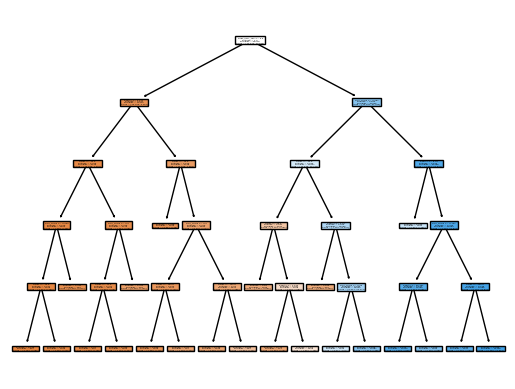

In [32]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(5, 10),
    'min_samples_split': np.arange(100, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(100, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf_exact = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf_exact, param_grid, n_iter=50, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf_exact = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf_exact.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf_exact.predict(X_test)
y_pred_proba = clf_exact.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC)
print(confusion_matrix(y_test, y_pred))
plot_tree(clf_exact, feature_names=['cases', 'admits','perc_covid', 'beds_over_15k'], filled=True)
#plt.savefig('Graphs/Optimized_CDC_classifier_with_output.png', dpi = 300)

In [ ]:
best_params
clf_exact = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')


In [33]:
model_name = f"CDC_optimized_exact_enhanced_auroc_{ROC:.4f}_unpruned.sav"
pickle.dump(clf_exact, open(model_name, 'wb'))


Number of nodes in the last tree is: 1 with ccp_alpha: 0.27068941584519113


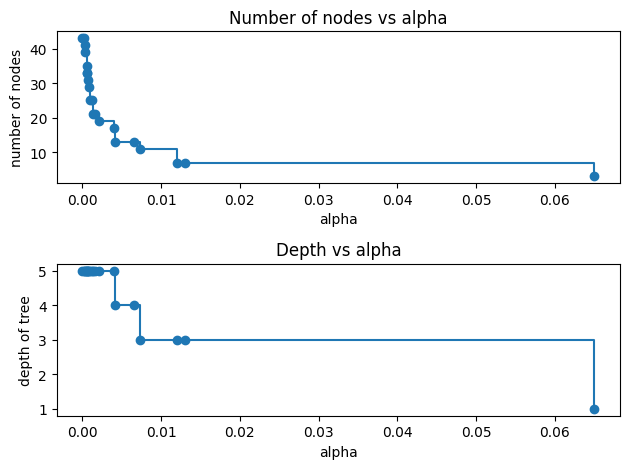

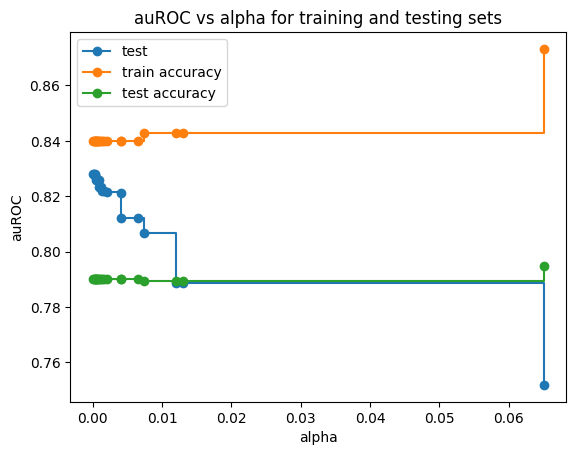

In [34]:

path = clf_exact.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=ccp_alpha,  class_weight='balanced')
    clf.fit(X_train, y_train,  sample_weight = weights )
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

test_scores = [roc_auc_score(y_test[0], clf.predict_proba(X_test)[:, 1]) for clf in clfs]
train_scores_accuracy = [clf.score(X_train, y_train) for clf in clfs]
test_scores_accuracy  = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("auROC")
ax.set_title("auROC vs alpha for training and testing sets")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.plot(ccp_alphas, train_scores_accuracy, marker="o", label="train accuracy", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_accuracy, marker="o", label="test accuracy", drawstyle="steps-post")
ax.legend()
plt.show()

Accuracy: 0.7899918798213561
auROC: 0.8279791768990968


[Text(0.484375, 0.9166666666666666, 'beds_over_15k <= 0.5\nentropy = 1.0\nsamples = 65578\nvalue = [40.833, 40.833]'),
 Text(0.25, 0.75, 'admits <= 0.417\nentropy = 0.517\nsamples = 11373\nvalue = [26.466, 3.461]'),
 Text(0.15625, 0.5833333333333334, 'cases <= 43.5\nentropy = 0.355\nsamples = 5335\nvalue = [15.233, 1.097]'),
 Text(0.09375, 0.4166666666666667, 'perc_covid <= 0.003\nentropy = 0.279\nsamples = 2562\nvalue = [7.969, 0.405]'),
 Text(0.0625, 0.25, 'cases <= 13.5\nentropy = 0.257\nsamples = 2306\nvalue = [7.344, 0.333]'),
 Text(0.03125, 0.08333333333333333, 'entropy = 0.195\nsamples = 820\nvalue = [2.782, 0.086]'),
 Text(0.09375, 0.08333333333333333, 'entropy = 0.291\nsamples = 1486\nvalue = [4.562, 0.246]'),
 Text(0.125, 0.25, 'entropy = 0.481\nsamples = 256\nvalue = [0.625, 0.072]'),
 Text(0.21875, 0.4166666666666667, 'perc_covid <= 0.0\nentropy = 0.426\nsamples = 2773\nvalue = [7.264, 0.692]'),
 Text(0.1875, 0.25, 'cases <= 77.5\nentropy = 0.401\nsamples = 2525\nvalue = [6

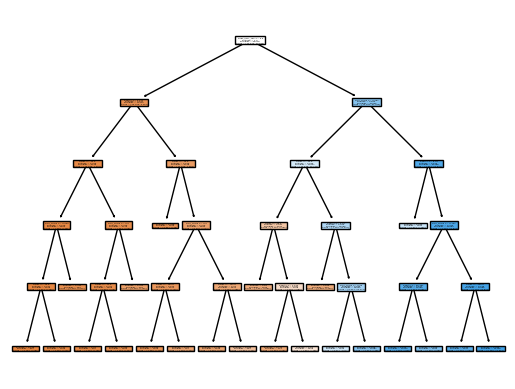

In [36]:
# best one
clf_exact = clfs[test_scores.index(max(test_scores))]

# Train the decision tree classifier
clf_exact.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set

y_pred = clf_exact.predict(X_test)
y_pred_proba = clf_exact.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC)
plot_tree(clf_exact, feature_names=['cases', 'admits','perc_covid', 'beds_over_15k'], filled=True)
#plt.savefig('Graphs/Optimized_CDC_classifier_with_output.png', dpi = 300)

In [37]:
model_name = f"CDC_optimized_exact_enhanced_auroc_{ROC:.4f}_pruned.sav"
pickle.dump(clf_exact, open(model_name, 'wb'))

In [236]:
conf_matrix = confusion_matrix(y_test, y_pred)

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

# Calculate specificity (true negative rate)
specificity = TN / (TN + FP)
print(specificity)
# Calculate sensitivity (true positive rate)
sensitivity = TP / (TP + FN)
print(sensitivity)

ppv, npv = calculate_ppv_npv(conf_matrix)
print(ppv)
print(npv)

0.6310210935040403
0.8726219603535228
0.8325076219512195
0.7021251751517982


# Plotting the optimised CDC classifiers

In [154]:
import string

def add_labels_to_subplots(axs, hfont, height):
    labels_subplots = list(string.ascii_uppercase)
    for i, ax in enumerate(axs):
        ax.text(ax.get_xlim()[0], ax.get_ylim()[1] * height, labels_subplots[i], fontsize=30, **hfont)
    return labels_subplots

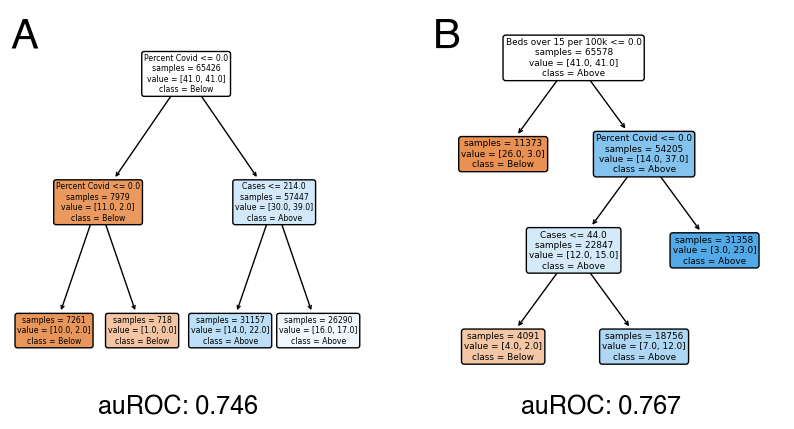

In [165]:
fig, axs = plt.subplots(1,2, figsize=(10, 5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
CDC_exact = pickle.load(open("CDC_optimized_exact_auroc_0.7461.sav", 'rb'))
CDC_exact_enhanced = pickle.load(open("CDC_optimized_exact_auroc_0.7666378_ccp.sav", 'rb'))
axs.ravel()
auROC = [0.746, 0.767]
plot_tree(CDC_exact, ax=axs[0], feature_names=['Cases', 'Admits','Percent Covid'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=0)
plot_tree(CDC_exact_enhanced, ax=axs[1], feature_names=['Cases', 'Admits','Percent Covid', 'Beds over 15 per 100k'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=0)
#plt.tight_layout()
add_labels_to_subplots(axs, hfont, 0.9)
for i, ax in enumerate(axs):
        ax.text(ax.get_xlim()[1]/4, ax.get_ylim()[1] * -0.05, f'auROC: {auROC[i]}', fontsize=18, **hfont)
plt.savefig('Graphs/CDC_classifiers_all.png', dpi = 300)


In [238]:
CDC_exact_enhanced = pickle.load(open("CDC_optimized_exact_auroc_0.7666378_ccp.sav", 'rb'))
CDC_exact_enhanced

DecisionTreeClassifier(ccp_alpha=0.0130471505, class_weight='balanced',
                       criterion='entropy', min_samples_leaf=1004,
                       min_samples_split=1041, random_state=10)